# Исследовательский анализ данных

## Описание проекта

**Определение возраста покупателей**

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

### Загрузка библиотек:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import warnings
warnings.filterwarnings('ignore')

### Загрузка файлов:

In [2]:
try:
    data = pd.read_csv('/datasets/faces/labels.csv')
except:
    data = pd.read_csv('labels.csv')

### Обзор данных:

In [3]:
def data_check (data_file):
    display(data_file.head())
    data_file.info()
    print('Количество пропусков', data_file.isna().sum().sum())
    print('Количество дубликатов:', sum(data_file.duplicated()))
    return 

In [4]:
data_check(data)

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB
Количество пропусков 0
Количество дубликатов: 0


Мы не видим никаких аномалий в выборке. Далее нам нужно извлечь изображения с помощью метода "ImageDataGenerator".

In [5]:
datagen = ImageDataGenerator()

In [6]:
datagen_flow = datagen.flow_from_directory(
    # папка, в которой хранится датасет
    '/datasets/faces/',
    # к какому размеру приводить изображения
    target_size=(150, 150), 
    # размер батча
    batch_size=16,
    # в каком виде выдавать метки классов
    class_mode='sparse',
    # фиксируем генератор случайных чисел (от англ. random seed)
    seed=12345) 

Found 7591 images belonging to 1 classes.


In [7]:
print('Количество батчей:', len(datagen_flow))

Количество батчей: 475


In [8]:
features, target = next(datagen_flow)
print('Размер выборки:', features.shape) 
print('Размер целевой выборки:', target.shape) 

Размер выборки: (16, 150, 150, 3)
Размер целевой выборки: (16,)


### Построим график распределения возраста в выборке:

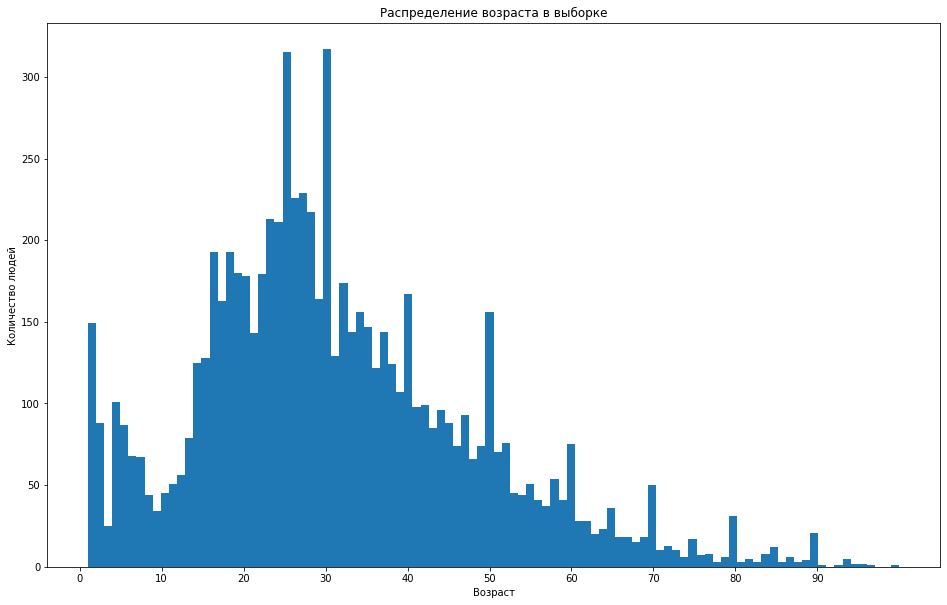

In [10]:
plt.figure(figsize=(16, 10))
plt.hist(data['real_age'], bins=100)
plt.xticks(np.arange(0, 100, step=10))
plt.title("Распределение возраста в выборке")
plt.gca().set(xlabel='Возраст', ylabel='Количество людей');

По данной гистограмме, можно сделать вывод, что большую часть посетителей магазина составляют люди в возрасте от 20 до 40 лет. Самый большой пик мы видим в промежутке от 20 до 30 лет. 

### Печать примеров изображений:

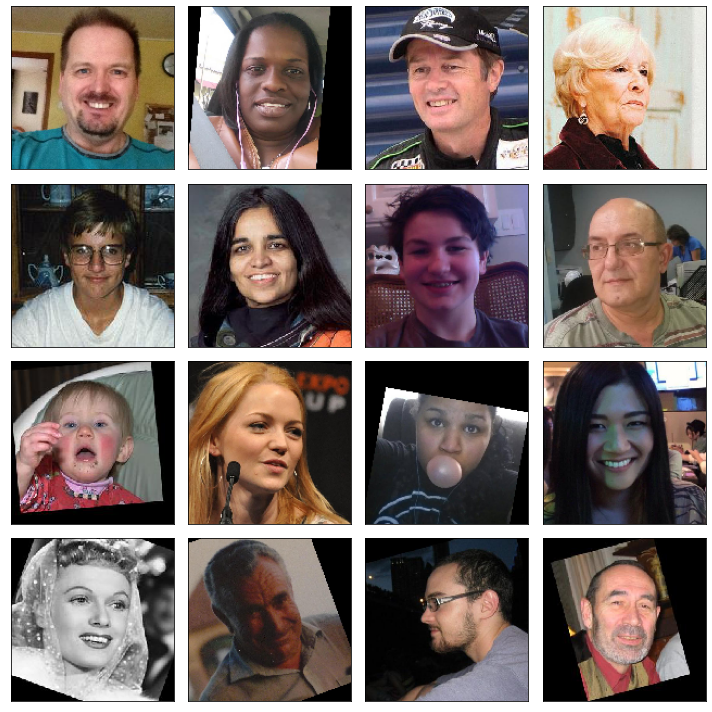

In [11]:
fig = plt.figure(figsize=(10,10))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i]/255)
	# для компактности удаляем оси и прижимаем изображения друг к другу
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

**Вывод:** Проведя предварительный анализ выборки, мы можем сделать следующие выводы:
- В целом выборка имеент достаточно скромные размеры, которые имеют еще более меньшие разме для определенных категорий людей, в данном случае дети и пожилые люди. Если взять в пример CIFAR или ImageNet, для адекватного распределения нужно иметь в десять раз более насыщенные выборки, с равными делениями на признаки. 
- Исследовав гистограмму, мы можем увидеть некоторые странности в выборке. Во первых распределение возрастов имеет сильный разброс, с выбросами в 25, 30, 40, 50 лет. Создается впечатление будто присвоение возраста к фотографиям было чисто условным. Сложно предположить, что магазин больше всего посещают люди данных возрастов в принципе. Во вторых мы имеем странный пик в возрасте от 0 до 5 лет. Можно допустить что после 5-6 лет ребенок может быть с родителем и попасть на камеру, но не более того.К Камеры не заглядывают в коляски. 
- При просмотре данной выборки, сразу встает вопрос об ее полезности в данном проекти в принципе. Если мы рассматриваем концепт "магазина", то желательно иметь фотографии покупателей в "реалистичных условиях обитания", без различных фильтров, обрезов и неудачных ракурсов. Помимо этого мы имеем фотографии из разных "эпох" (если это можно так назвать), и для большей полезности, датасет должен быть составлен из актуальных изображений людей, чтобы создать правильное распределение по возрастам. 

### Обучение модели:

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, GlobalAveragePooling2D
import numpy as np
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
import pandas as pd

def load_train(path):
    datagen = ImageDataGenerator(validation_split=0.25,=1./255)
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen_flow = datagen.flow_from_dataframe(dataframe=labels,
                                                     directory=path + 'final_files/',
                                                     x_col='file_name',
                                                     y_col='real_age',
                                                     target_size=(224, 224),
                                                     batch_size=16,
                                                     class_mode='raw',
                                                     subset='training',
                                                     seed=12345)
    return train_datagen_flow

def load_test(path):
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen_flow = datagen.flow_from_dataframe(dataframe=labels,
                                                     directory=path + 'final_files/',
                                                     x_col='file_name',
                                                     y_col='real_age',
                                                     target_size=(224, 224),
                                                     batch_size=16,
                                                     class_mode='raw',
                                                     subset='validation',
                                                     seed=12345)
    return test_datagen_flow

def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape, weights='imagenet', include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=1, activation='relu'))

    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=5,
               steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps=len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model

### Результаты обсчета модели:

## Вывод:

Согласно данному заданию, модель должна распознавать лица посетителей магазина для следующих целей:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

Условием работы модели было достижение порога MAE не более 8, что удалось достичь в данном случае MAE = 6,2553.